In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from scipy.stats import shapiro,skew,kstest,normaltest

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import warnings
warnings.filterwarnings("ignore")

# Problem Statement

# Data Gathering

In [252]:
df=pd.read_csv("medical_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# EDA

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [254]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Feature Enginnering

## age

<AxesSubplot:xlabel='age'>

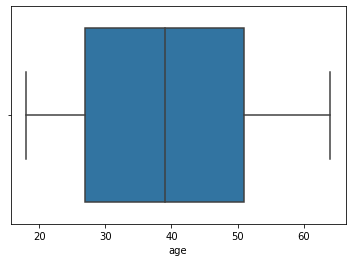

In [255]:
sns.boxplot(x=df["age"])

## Sex

In [256]:
df.replace({"male":1,"female":0},inplace=True)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [257]:
sex_value={"male":1,"female":0}
sex_value

{'male': 1, 'female': 0}

## bmi

<AxesSubplot:xlabel='bmi'>

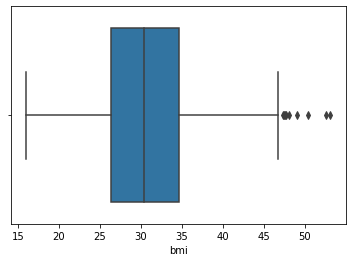

In [259]:
sns.boxplot(x=df["bmi"])

In [260]:
q1=df["bmi"].quantile(0.25)
q3=df["bmi"].quantile(0.75)
iqr=q3-q1
upper_tail=q3+1.5*iqr
lower_tail=q1-1.5*iqr
print(upper_tail)
print(lower_tail)

47.290000000000006
13.7


In [261]:
# Here we put the value of lower tail  and upper tail
df.loc[df['bmi'] < lower_tail, 'bmi'] = lower_tail
df.loc[df['bmi'] > upper_tail, 'bmi'] = upper_tail

# Find the median value between the lower tail and upper tail
median_bmi = df[['bmi']].loc[(df['bmi'] < upper_tail) &
                (df['bmi'] > lower_tail)].median()[0]
median_bmi

# put the median value to outlier
df.loc[(df['bmi'] > upper_tail) |
                (df['bmi'] < lower_tail), 'bmi'] = median_bmi

<AxesSubplot:xlabel='bmi'>

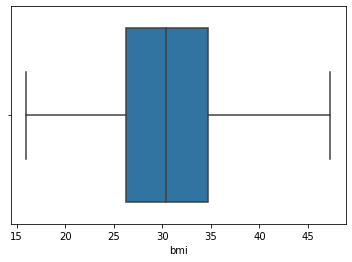

In [262]:
sns.boxplot(x=df["bmi"])

## children

<AxesSubplot:xlabel='children'>

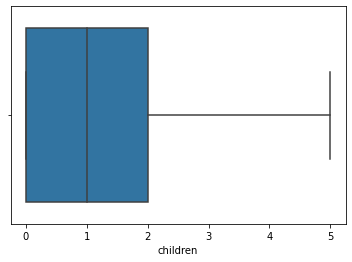

In [263]:
sns.boxplot(x=df["children"])

## smoker

In [264]:
df.replace({"yes":1,"no":0},inplace=True)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [265]:
smoker_value={"yes":1,"no":0}
smoker_value

{'yes': 1, 'no': 0}

## region

In [266]:
df["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [267]:
df=pd.get_dummies(df,columns=["region"])

In [268]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


# Feature Selection

In [269]:
# Linearity
df.corr()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,-0.020856,0.111930,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.044802,0.017163,0.076185,0.057292,-0.002425,-0.011156,0.017117,-0.004184
bmi,0.111930,0.044802,1.000000,0.013700,0.003146,0.198997,-0.138075,-0.135672,0.268556,-0.005087
children,0.042469,0.017163,0.013700,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003146,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198997,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
region_northeast,0.002475,-0.002425,-0.138075,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,-0.011156,-0.135672,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.017117,0.268556,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.004184,-0.005087,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


<AxesSubplot:>

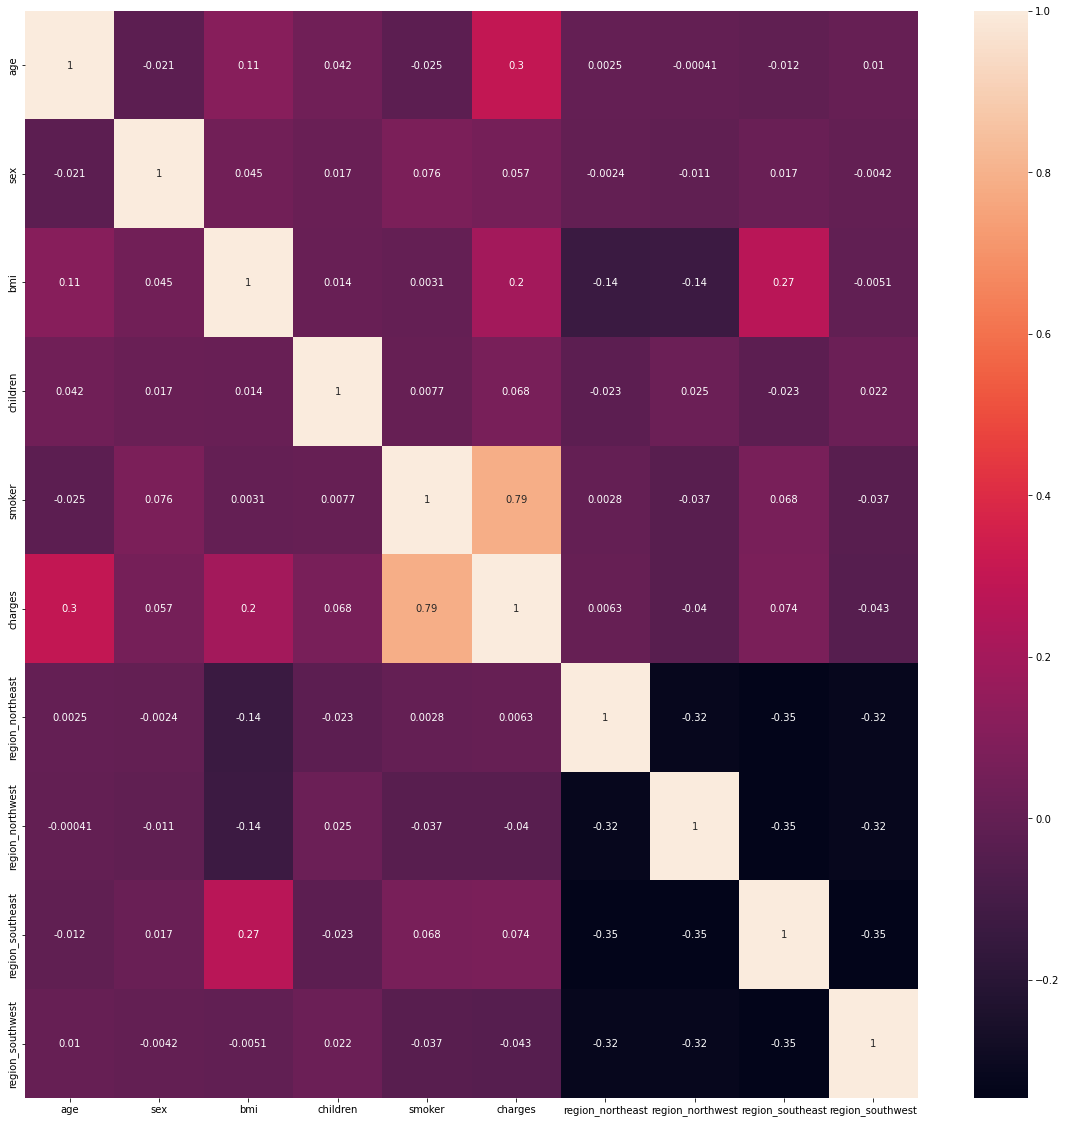

In [270]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

In [271]:
x=df.drop("charges",axis=1)
x.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0,0,0,1
1,18,1,33.770,1,0,0,0,1,0
2,28,1,33.000,3,0,0,0,1,0
3,33,1,22.705,0,0,0,1,0,0
4,32,1,28.880,0,0,0,1,0,0


In [272]:
# 2 No multicolinearity
vif_list=[]
x.shape[1]
for i in range(x.shape[1]):
    vif=variance_inflation_factor(x,i)
    vif_list.append(vif)
print(vif_list)
s1=pd.Series(vif_list,index=x.columns)
s1


[1.0174619308223147, 1.008755362473221, 1.1064200096251202, 1.0040334014255623, 1.0120840759479972, 8.663859852004945, 8.698010898139458, 11.606448983221165, 9.286823633783708]


age                  1.017462
sex                  1.008755
bmi                  1.106420
children             1.004033
smoker               1.012084
region_northeast     8.663860
region_northwest     8.698011
region_southeast    11.606449
region_southwest     9.286824
dtype: float64

<AxesSubplot:>

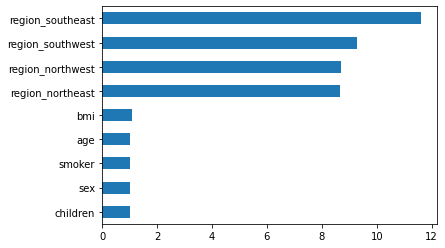

In [273]:
s1.sort_values().plot(kind = 'barh')

In [274]:
y=df["charges"]
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [275]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1070, 9)
(268, 9)
(1070,)
(268,)


In [276]:
# create instance of model
model=LinearRegression()

#fitting the model
model.fit(x_train,y_train)


LinearRegression()

In [277]:
# Model prediction for testing dataset
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("MSE :",mse)
print("RMSE :",rmse)
print("MAE :",mae)
print("R_squared :",r2)

MSE : 33743973.149191536
RMSE : 5808.956287423029
MAE : 4197.2602908912795
R_squared : 0.782645740000912


In [278]:
# Model prediction for training dataset
y_train_pred=model.predict(x_train)
mse=mean_squared_error(y_train,y_train_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_train,y_train_pred)
r2=r2_score(y_train,y_train_pred)

print("MSE :",mse)
print("RMSE :",rmse)
print("MAE :",mae)
print("R_squared :",r2)

MSE : 37223790.70792783
RMSE : 6101.130281179696
MAE : 4212.223922437563
R_squared : 0.7420989634336961


In [279]:
# We find the residual
residual=y_test-y_pred
residual

764       147.854037
887     -1800.426619
890     -7500.627044
1293     -135.911697
259      6756.775687
            ...     
109      7981.220761
575       479.185111
535     -1621.037420
543     22828.062187
846     -2454.560966
Name: charges, Length: 268, dtype: float64

## Normality of Residual

<AxesSubplot:xlabel='charges', ylabel='Density'>

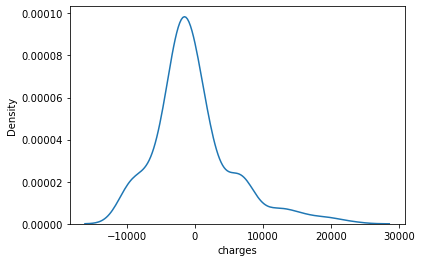

In [280]:
sns.kdeplot(residual)

In [281]:
skew(residual)

1.1299455577238835

In [282]:
_ , p_val=shapiro(residual)
print(p_val)
if p_val >= 0.05:
    print("Data is Normal")
else:
    print("Data is Not Normal")

3.011376911721264e-11
Data is Not Normal


## QQ plot

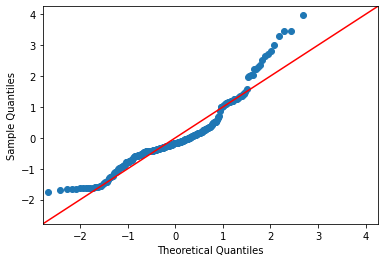

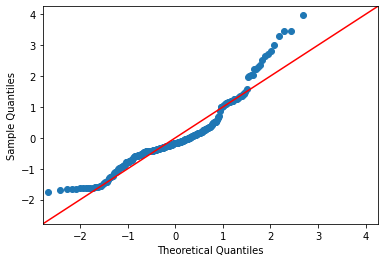

In [283]:
import statsmodels.api as sm
sm.qqplot(residual, line = '45', fit = True)

## Homoscedasticity

<AxesSubplot:xlabel='charges', ylabel='charges'>

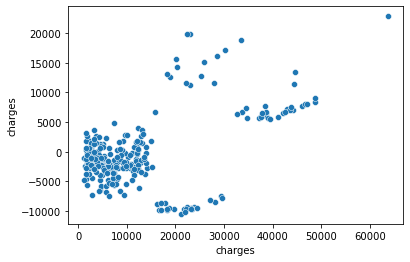

In [284]:
sns.scatterplot(x= y_test, y= residual)

# Testing on a singal row

In [285]:
x_test.head(1)

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
764,45,0,25.175,2,0,1,0,0,0


In [286]:
column_names = x.columns
column_names

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [287]:
age =35
sex ="male"
bmi =29.135
children =2
smoker ="yes"
region = "northeast"

In [288]:
print(sex_value)
print(smoker_value)
print(column_names)

{'male': 1, 'female': 0}
{'yes': 1, 'no': 0}
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


In [289]:
project_data={"sex":sex_value,"smoker":smoker_value,"columns":list(column_names)}
project_data

{'sex': {'male': 1, 'female': 0},
 'smoker': {'yes': 1, 'no': 0},
 'columns': ['age',
  'sex',
  'bmi',
  'children',
  'smoker',
  'region_northeast',
  'region_northwest',
  'region_southeast',
  'region_southwest']}

In [290]:
# For one hot encoding 
region="region_"+region
region

'region_northeast'

In [291]:
region_index=np.where(column_names==region)[0][0]
region_index

5

In [292]:
array=np.zeros(len(column_names),dtype=int)
array

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [293]:
array[0]=age
array[1]=project_data["sex"][sex]
array[2]=bmi
array[3]=children
array[4]=project_data["smoker"][smoker]
array[region_index]=1
array

array([35,  1, 29,  2,  1,  1,  0,  0,  0])

In [295]:
model.predict([array])[0]

31321.071735640064

In [296]:
import pickle
with open ("Linear_model_medical_ins.pkl","wb") as f:
    pickle.dump(model,f)

In [297]:
import json
with open ("medical_ins_project_data.json","w") as f:
    json.dump(project_data,f)